In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd
from tqdm.notebook import tqdm
from abc import ABC, abstractmethod
import time, functools
%matplotlib inline

In [13]:
class DataProcessing:
    
    def __init__(self, filepath):
        self.dataframe = pd.read_csv(filepath)
        
    def permutate_data(self, seed):
        np.random.seed(seed)
        indx = np.random.permutation(self.dataframe.shape[0])
        self.dataframe = self.dataframe.iloc[indx]
        
    def get_target(self, target_feature):
        self.target = self.dataframe[target_feature]
        self.features = self.dataframe.drop(columns=target_feature)
        return self.features, self.target
        
    def split_data(self, test_part, target_feature, norm = False):
        features, target = self.get_target(target_feature)
        if norm == True:
            features = (features - features.min()) / (features.max() - features.min())
        val = int(self.dataframe.shape[0] * test_part)
        return features[val : ].values, features[ : val].values, target[val : ].values, target[ : val].values
        

class LogisticRegression:
    
    def __init__(self, learning_rate=1e-2, num_iterations=1000, print_cost=False, optimizer='GD', **parameters):
        self.lr = learning_rate
        self.num_iterations = num_iterations
        self.print_cost = print_cost
        self.optimizer = optimizer
        if parameters:
            self.betas = parameters['betas']
            self.epsilon = parameters['epsilon']
        else:
            self.betas = (0.9, 0.999)
            self.epsilon = 1e-8
    
    @staticmethod
    def sigmoid(z):
        """
        Compute the sigmoid of z

        Arguments:
        z -- A scalar or numpy array of any size.

        Return:
        s -- sigmoid(z)
        """
        s = 1. / (1. + np.exp(-z))
        return s
    
    def initialize_with_zeros(self, dim):
        """
        This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.

        Argument:
        dim -- size of the w vector we want (or number of parameters in this case)

        Returns:
        w -- initialized vector of shape (dim, 1)
        b -- initialized scalar (corresponds to the bias)
        """
        self.w = np.zeros((dim))
        self.b = 0.
            
    def propagate(self, X, Y):
        """
        Implement the cost function and its gradient for the propagation explained above

        Arguments:
        w -- weights, a numpy array of size which equals the number of features
        b -- bias, a scalar
        X -- data 
        Y -- true "label" vector (containing 0 and 1) of size (1, number of examples)

        Return:
        cost -- negative log-likelihood cost for logistic regression
        dw -- gradient of the loss with respect to w, thus same shape as w
        db -- gradient of the loss with respect to b, thus same shape as b

        """
        m = X.shape[1]
        #print('number of objects = ',len(X))
        # FORWARD PROPAGATION (FROM X TO COST)
        A = self.sigmoid(np.dot(X, self.w) + self.b )    # compute activation
        self.cost = -(1. / m) * np.sum(Y * np.log(A) + (1 - Y) * np.log(1 - A))   # compute cost

        # BACKWARD PROPAGATION (TO FIND GRAD)
        self.dw = (1. / m) * np.dot(X.T, (A - Y))
        self.db = (1. / m) * np.sum(A - Y, axis = -1)
        
                
    def fit(self, X, Y):
        """
        This function optimizes w and b by running a gradient descent algorithm

        Arguments:
        w -- weights, a numpy array 
        b -- bias, a scalar
        X -- data 
        Y -- true "label" vector (containing 0 and 1), of shape (1, number of examples)
        num_iterations -- number of iterations of the optimization loop
        learning_rate -- learning rate of the gradient descent update rule
        print_cost -- True to print the loss every 100 steps

        Returns:
        params -- dictionary containing the weights w and bias b
        grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
        costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.

        """

        costs = []
        first_moment_w = 0
        second_moment_w = 0
        first_moment_b = 0
        second_moment_b = 0
        for i in tqdm(range(self.num_iterations)):

            # Cost and gradient calculation 
            self.propagate(X, Y)

            if self.optimizer == 'GD':
                self.w -= self.lr * self.dw
                self.b -= self.lr * self.db
                
            elif self.optimizer == 'Adam':
                first_moment_w = self.betas[0] * first_moment_w + (1 - self.betas[0]) * self.dw
                second_moment_w = self.betas[1] * second_moment_w + (1 - self.betas[1]) * self.dw**2
                first_moment_w_hat = first_moment_w / (1 - self.betas[0]**(i + 1))
                second_moment_w_hat = second_moment_w / (1 - self.betas[1]**(i + 1))
                
                first_moment_b = self.betas[0] * first_moment_b + (1 - self.betas[0]) * self.db
                second_moment_b = self.betas[1] * second_moment_b + (1 - self.betas[1]) * self.db**2
                first_moment_b_hat = first_moment_b / (1 - self.betas[0]**(i + 1))
                second_moment_b_hat = second_moment_b / (1 - self.betas[1]**(i + 1))

                self.w -= self.lr * first_moment_w_hat / (np.sqrt(second_moment_w_hat) + self.epsilon)
                self.b -= self.lr * first_moment_b_hat / (np.sqrt(second_moment_b_hat) + self.epsilon)                

            # Record the costs
            if i % 100 == 0:
                costs.append(self.cost)

            # Print the cost every 100 training iterations
            if self.print_cost and i % 100 == 0:
                print ("Cost after iteration %i: %f" %(i, self.cost))
                
        self.costs = costs
        return None
        
    def predict(self, X):
        '''
        Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)

        Arguments:
        w -- weights, a numpy array 
        b -- bias, a scalar
        X -- data 

        Returns:
        Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
        '''

        Y_prediction = np.zeros((X.shape[0]))
        # Compute vector "A" predicting the probabilities 
        A = self.sigmoid(np.dot(X, self.w) + self.b)

        for i in range(A.shape[0]):
            # Convert probabilities A[0,i] to actual predictions p[0,i]
            if (A[i] <= 0.5):
                
                Y_prediction[i] = 0
            else:
                Y_prediction[i] = 1

        return Y_prediction
    
    def fit_and_evaluate(self, X_train, Y_train, X_test, Y_test):
        """
        Builds the logistic regression model by calling the function we've implemented previously

        Arguments:
        X_train -- training set represented by a numpy array 
        Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
        X_test -- test set represented by a numpy array 
        Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
        num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
        learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
        print_cost -- Set to true to print the cost every 100 iterations

        Returns:
        d -- dictionary containing information about the model.
        """

        # initialize parameters with zeros 
        self.initialize_with_zeros(X_train.shape[1])

        # Gradient descent
        self.fit(X_train, Y_train)

        # Predict test/train set examples
        Y_prediction_test = self.predict(X_test)
        Y_prediction_train = self.predict(X_train)

        # Print train/test Errors
        print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
        print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

        d = {"costs": self.costs,
             "Y_prediction_test": Y_prediction_test, 
             "Y_prediction_train" : Y_prediction_train, 
             "w" : self.w, 
             "b" : self.b,
             "learning_rate" : self.lr,
             "num_iterations": self.num_iterations}

        return d

In [14]:
processing = DataProcessing(filepath = './bioresponse.csv')
processing.permutate_data(seed = 1000)
x_train, x_test, y_train, y_test = processing.split_data(0.35, 'Activity', norm=True)

## Training

### Gradient Descent

  0%|          | 0/2000 [00:00<?, ?it/s]

train accuracy: 82.98482984829849 %
test accuracy: 75.9908536585366 %


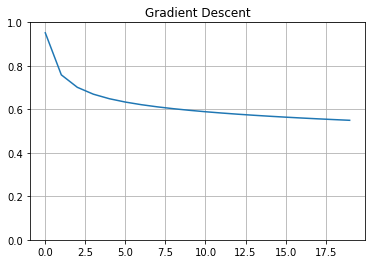

In [23]:
classifier = LogisticRegression(learning_rate=3e-2, num_iterations=2000, optimizer='GD')
result = classifier.fit_and_evaluate(x_train, y_train, x_test, y_test)

plt.title('Gradient Descent')
plt.plot(result['costs'])
plt.ylim(0, 1)
plt.grid()
plt.show()

### Adam

  0%|          | 0/2000 [00:00<?, ?it/s]

train accuracy: 87.20787207872078 %
test accuracy: 74.39024390243902 %


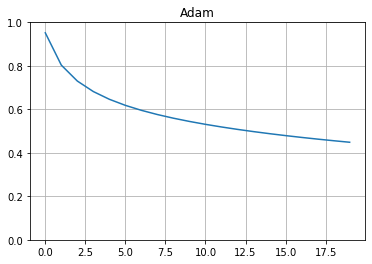

In [27]:
classifier = LogisticRegression(learning_rate=3e-4, num_iterations=2000, optimizer='Adam')
result = classifier.fit_and_evaluate(x_train, y_train, x_test, y_test)

plt.title('Adam')
plt.plot(result['costs'])
plt.ylim(0, 1)
plt.grid()
plt.show()